In [ ]:
import pandas as pd
import numpy as np
from matplotlib import rc
import itertools
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import folium
#rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False
pd.options.display.float_format = '{:.8f}'.format

### 그래프 한글 깨짐 문제 해결 코드 

In [ ]:
# 한글 문제
# matplotlib의 기본 폰트에서 한글이 지원되지 않기 때문에
# matplotlib의 폰트 변경 필요
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

### 음식물쓰레기 데이터 시각화

In [ ]:
fw = pd.read_csv('../data/01_제공데이터_update(210811)/01_음식물쓰레기_FOOD_WASTE_210811_update.CSV', encoding = 'cp949')
fw = fw.drop(['Unnamed: 0'], axis = 1)
fw['year'] = fw.base_date.dt.year
fw['month'] = fw.base_date.dt.month

In [ ]:
fw1 = fw.groupby(['year', 'month']).mean().reset_index()

In [ ]:
fw1_18 = fw1[fw1.year == 2018][['em_g']]
fw1_19 = fw1[fw1.year == 2019][['em_g']]
fw1_20 = fw1[fw1.year == 2020][['em_g']]

In [ ]:
month = np.arange(1,13)

fig, ax = plt.subplots()
ax.plot(month,fw1_18, month, fw1_19, month, fw1_20)
ax.legend(['2018', '2019',' 2020'])
ax.set_xticks(np.arange(1,13))
plt.show()

### 장기체류외국인유동인구 데이터 가공

In [ ]:
lt_frgn = pd.read_csv('../data/01_제공데이터_update(210811)/02-2_장기체류외국인유동인구_LONG_TERM_FRGN.csv', encoding = 'cp949')
lt_frgn

,base_date,time,nationality,city,emd_cd,emd_nm,resd_pop_cnt,work_pop_cnt,visit_pop_cnt,resd
0,2018-01-01,1,CAN,제주시,50110250,한림읍,6.33810000,0.00000000,4.58020000,제주
1,2018-01-01,1,CHN,제주시,50110250,한림읍,442.10910000,0.00000000,5.70510000,제주
2,2018-01-01,1,CHN,제주시,50110250,한림읍,0.00000000,7.86950000,51.34610000,그외
3,2018-01-01,1,DEU,제주시,50110250,한림읍,0.00000000,0.00000000,8.20990000,그외
4,2018-01-01,1,ETC,제주시,50110250,한림읍,15.91840000,0.00000000,2.87580000,제주
...,...,...,...,...,...,...,...,...,...,...
23837312,2021-06-30,24,THA,서귀포시,50130620,예래동,0.00000000,0.00000000,3.35580000,제주
23837313,2021-06-30,24,TWN,서귀포시,50130620,예래동,0.00000000,0.00000000,12.26550000,그외
23837314,2021-06-30,24,USA,서귀포시,50130620,예래동,22.06240000,0.00000000,0.00000000,제주
23837315,2021-06-30,24,USA,서귀포시,50130620,예래동,0.00000000,0.00000000,26.47490000,그외


In [ ]:
# LF_FRGN 데이터 가공

lt_frgn = lt_frgn[['base_date', 'time', 'nationality', 'city', 'emd_nm', 'resd_pop_cnt', 'work_pop_cnt', 'visit_pop_cnt','resd']]
lt_frgn.rename(columns ={'resd_pop_cnt' : 'lf_resd_pop_cnt', 'work_pop_cnt':'lf_work_pop_cnt', 'visit_pop_cnt':'lf_visit_pop_cnt'}, inplace = True)

lt_frgn_jeju = lt_frgn[lt_frgn.resd =='제주']
lt_frgn_notjeju = lt_frgn[lt_frgn.resd =='그외']
lt_frgn_notjeju.rename(columns = {'lf_work_pop_cnt':'nj_lf_work_pop_cnt', 'lf_visit_pop_cnt':'nj_lf_visit_pop_cnt'}, inplace = True)

lt_frgn = pd.merge(lt_frgn_jeju, lt_frgn_notjeju, on=['base_date','time','nationality','city','emd_nm'], how = 'outer')
lt_frgn = lt_frgn.fillna(0).drop(['resd_x', 'resd_y','lf_resd_pop_cnt_y'], axis = 1).rename(columns = {'lf_resd_pop_cnt_x':'lf_resd_pop_cnt'})

# 필요한 국적에 대한 데이터만 남기기
new_lf_data = lt_frgn[lt_frgn.nationality.isin(['JPN', 'CHN', 'TWN', 'MYS', 'VNM', 'THA', 'USA'])].groupby(['base_date', 'emd_nm','nationality']).sum().drop(['time'], axis = 1)
new_lf_data = new_lf_data.unstack().reset_index().fillna(0)

# 컬럼명 변경
col_name = list(itertools.product(['lf_resd_pop_cnt', 'lf_work_pop_cnt', 'lf_visit_pop_cnt', 'nj_lf_work_pop_cnt','nj_lf_visit_pop_cnt'], ['CHN', 'JPN', 'MYS', 'THA', 'TWN', 'USA', 'VNM']))
col_list = [i+'_'+j for i, j in col_name]
col_list = ['base_date', 'emd_nm'] + col_list
new_lf_data.columns = col_list


new_lf_data = new_lf_data.fillna(0)

C:\Users\82109\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [ ]:
def year(i):
    i=i.split('-')[0]
    return i

In [ ]:
new_lf_data['연도']=new_lf_data['base_date'].map(lambda x: year(x))
new_lf_data

,base_date,emd_nm,lf_resd_pop_cnt_CHN,lf_resd_pop_cnt_JPN,lf_resd_pop_cnt_MYS,lf_resd_pop_cnt_THA,lf_resd_pop_cnt_TWN,lf_resd_pop_cnt_USA,lf_resd_pop_cnt_VNM,lf_work_pop_cnt_CHN,...,nj_lf_work_pop_cnt_USA,nj_lf_work_pop_cnt_VNM,nj_lf_visit_pop_cnt_CHN,nj_lf_visit_pop_cnt_JPN,nj_lf_visit_pop_cnt_MYS,nj_lf_visit_pop_cnt_THA,nj_lf_visit_pop_cnt_TWN,nj_lf_visit_pop_cnt_USA,nj_lf_visit_pop_cnt_VNM,연도
0,2018-01-01,건입동,1061.20640000,500.35130000,0.00000000,0.00000000,329.67040000,0.00000000,577.01560000,166.11970000,...,0.00000000,74.21740000,1517.69160000,0.00000000,9.07280000,0.00000000,0.00000000,128.84240000,793.77090000,2018
1,2018-01-01,구좌읍,2027.65710000,107.31810000,0.00000000,153.26110000,0.00000000,177.87690000,912.18950000,94.79850000,...,0.00000000,139.11210000,429.24400000,11.84450000,0.00000000,35.44260000,206.89390000,74.85250000,6.69240000,2018
2,2018-01-01,남원읍,1449.47730000,0.00000000,0.00000000,0.00000000,0.00000000,7.32900000,344.39750000,0.00000000,...,0.00000000,37.14430000,235.11510000,0.00000000,13.55910000,35.45540000,20.65700000,16.09360000,87.45690000,2018
3,2018-01-01,노형동,33160.14580000,443.95170000,0.00000000,271.39660000,1175.10280000,1468.23860000,4347.18070000,1856.25780000,...,0.00000000,120.67760000,1070.36580000,5.98350000,0.00000000,0.00000000,114.29090000,102.11080000,1069.32520000,2018
4,2018-01-01,대륜동,1314.57220000,115.76380000,0.00000000,0.00000000,14.27500000,555.61000000,0.00000000,150.23710000,...,0.00000000,0.00000000,297.70950000,17.93240000,13.66060000,15.36930000,0.00000000,91.18490000,26.92470000,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54906,2021-06-30,표선면,1650.71990000,0.00000000,0.00000000,83.89510000,0.00000000,123.55000000,90.60960000,10.48080000,...,101.48750000,0.00000000,576.44190000,75.58550000,0.00000000,0.00000000,12.26550000,211.79990000,33.97840000,2021
54907,2021-06-30,한경면,1839.37350000,41.99200000,0.00000000,0.00000000,0.00000000,467.72320000,1547.89860000,167.69210000,...,0.00000000,0.00000000,1063.79740000,0.00000000,0.00000000,33.55820000,0.00000000,480.96070000,460.59400000,2021
54908,2021-06-30,한림읍,6529.51350000,0.00000000,0.00000000,765.12950000,0.00000000,763.36010000,2718.26080000,151.97160000,...,0.00000000,30.20320000,2148.55590000,29.39430000,8.46100000,261.75480000,0.00000000,781.01010000,789.05080000,2021
54909,2021-06-30,화북동,2651.63230000,503.90010000,0.00000000,0.00000000,0.00000000,211.80000000,422.84060000,267.25950000,...,0.00000000,0.00000000,193.89430000,4.19920000,0.00000000,0.00000000,12.26550000,8.82500000,184.99220000,2021


### 음식물쓰레기 데이터 불러오기

In [ ]:
FOOD_WASTE = pd.read_csv('../data/01_제공데이터_update(210811)/01_음식물쓰레기_FOOD_WASTE_210811_update.csv',encoding = 'cp949')
FOOD_WASTE=FOOD_WASTE[['base_date','em_g','emd_nm']]
FOOD_WASTE

C:\Users\82109\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,base_date,em_g,emd_nm
0,2018-01-01,15500,외도동
1,2018-01-01,59800,아라동
2,2018-01-01,25350,아라동
3,2018-01-01,30000,아라동
4,2018-01-01,44050,아라동
...,...,...,...
2211440,2021-06-30,58250,한림읍
2211441,2021-06-30,111000,한림읍
2211442,2021-06-30,48300,한림읍
2211443,2021-06-30,22050,한림읍


### 음식물 쓰레기 데이터와 독립변수 합치기

In [ ]:
final=pd.merge(FOOD_WASTE,new_lf_data,how='inner',on=['emd_nm','base_date'])
final

,base_date,em_g,emd_nm,lf_resd_pop_cnt_CHN,lf_resd_pop_cnt_JPN,lf_resd_pop_cnt_MYS,lf_resd_pop_cnt_THA,lf_resd_pop_cnt_TWN,lf_resd_pop_cnt_USA,lf_resd_pop_cnt_VNM,...,nj_lf_work_pop_cnt_USA,nj_lf_work_pop_cnt_VNM,nj_lf_visit_pop_cnt_CHN,nj_lf_visit_pop_cnt_JPN,nj_lf_visit_pop_cnt_MYS,nj_lf_visit_pop_cnt_THA,nj_lf_visit_pop_cnt_TWN,nj_lf_visit_pop_cnt_USA,nj_lf_visit_pop_cnt_VNM,연도
0,2018-01-01,15500,외도동,1313.43760000,344.55640000,0.00000000,159.66850000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,160.26900000,0.00000000,0.00000000,0.00000000,0.00000000,16.15440000,26.92060000,2018
1,2018-01-01,17350,외도동,1313.43760000,344.55640000,0.00000000,159.66850000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,160.26900000,0.00000000,0.00000000,0.00000000,0.00000000,16.15440000,26.92060000,2018
2,2018-01-01,41350,외도동,1313.43760000,344.55640000,0.00000000,159.66850000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,160.26900000,0.00000000,0.00000000,0.00000000,0.00000000,16.15440000,26.92060000,2018
3,2018-01-01,13000,외도동,1313.43760000,344.55640000,0.00000000,159.66850000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,160.26900000,0.00000000,0.00000000,0.00000000,0.00000000,16.15440000,26.92060000,2018
4,2018-01-01,26850,외도동,1313.43760000,344.55640000,0.00000000,159.66850000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,160.26900000,0.00000000,0.00000000,0.00000000,0.00000000,16.15440000,26.92060000,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2209686,2021-06-30,275800,천지동,366.82660000,0.00000000,0.00000000,0.00000000,0.00000000,48.53750000,52.85540000,...,0.00000000,0.00000000,597.40330000,0.00000000,0.00000000,0.00000000,12.26550000,35.30000000,154.78990000,2021
2209687,2021-06-30,18250,천지동,366.82660000,0.00000000,0.00000000,0.00000000,0.00000000,48.53750000,52.85540000,...,0.00000000,0.00000000,597.40330000,0.00000000,0.00000000,0.00000000,12.26550000,35.30000000,154.78990000,2021
2209688,2021-06-30,21150,천지동,366.82660000,0.00000000,0.00000000,0.00000000,0.00000000,48.53750000,52.85540000,...,0.00000000,0.00000000,597.40330000,0.00000000,0.00000000,0.00000000,12.26550000,35.30000000,154.78990000,2021
2209689,2021-06-30,139150,천지동,366.82660000,0.00000000,0.00000000,0.00000000,0.00000000,48.53750000,52.85540000,...,0.00000000,0.00000000,597.40330000,0.00000000,0.00000000,0.00000000,12.26550000,35.30000000,154.78990000,2021


In [ ]:
final.columns

Index(['base_date', 'em_g', 'emd_nm', 'lf_resd_pop_cnt_CHN',
       'lf_resd_pop_cnt_JPN', 'lf_resd_pop_cnt_MYS', 'lf_resd_pop_cnt_THA',
       'lf_resd_pop_cnt_TWN', 'lf_resd_pop_cnt_USA', 'lf_resd_pop_cnt_VNM',
       'lf_work_pop_cnt_CHN', 'lf_work_pop_cnt_JPN', 'lf_work_pop_cnt_MYS',
       'lf_work_pop_cnt_THA', 'lf_work_pop_cnt_TWN', 'lf_work_pop_cnt_USA',
       'lf_work_pop_cnt_VNM', 'lf_visit_pop_cnt_CHN', 'lf_visit_pop_cnt_JPN',
       'lf_visit_pop_cnt_MYS', 'lf_visit_pop_cnt_THA', 'lf_visit_pop_cnt_TWN',
       'lf_visit_pop_cnt_USA', 'lf_visit_pop_cnt_VNM',
       'nj_lf_work_pop_cnt_CHN', 'nj_lf_work_pop_cnt_JPN',
       'nj_lf_work_pop_cnt_MYS', 'nj_lf_work_pop_cnt_THA',
       'nj_lf_work_pop_cnt_TWN', 'nj_lf_work_pop_cnt_USA',
       'nj_lf_work_pop_cnt_VNM', 'nj_lf_visit_pop_cnt_CHN',
       'nj_lf_visit_pop_cnt_JPN', 'nj_lf_visit_pop_cnt_MYS',
       'nj_lf_visit_pop_cnt_THA', 'nj_lf_visit_pop_cnt_TWN',
       'nj_lf_visit_pop_cnt_USA', 'nj_lf_visit_pop_cnt_VNM', '연도

In [ ]:
final['CHN']=final['lf_resd_pop_cnt_CHN']+final['lf_work_pop_cnt_CHN']+final['nj_lf_work_pop_cnt_CHN']+final['nj_lf_visit_pop_cnt_CHN']
final['JPN']=final['lf_resd_pop_cnt_JPN']+final['lf_work_pop_cnt_JPN']+final['nj_lf_work_pop_cnt_JPN']+final['nj_lf_visit_pop_cnt_JPN']
final['TWN']=final['lf_resd_pop_cnt_TWN']+final['lf_work_pop_cnt_TWN']+final['nj_lf_work_pop_cnt_TWN']+final['nj_lf_visit_pop_cnt_TWN']
final['USA']=final['lf_resd_pop_cnt_USA']+final['lf_work_pop_cnt_USA']+final['nj_lf_work_pop_cnt_USA']+final['nj_lf_visit_pop_cnt_USA']
final['MYS']=final['lf_resd_pop_cnt_MYS']+final['lf_work_pop_cnt_MYS']+final['nj_lf_work_pop_cnt_MYS']+final['nj_lf_visit_pop_cnt_MYS']
final['VNM']=final['lf_resd_pop_cnt_VNM']+final['lf_work_pop_cnt_VNM']+final['nj_lf_work_pop_cnt_VNM']+final['nj_lf_visit_pop_cnt_VNM']
final['THA']=final['lf_resd_pop_cnt_THA']+final['lf_work_pop_cnt_THA']+final['nj_lf_work_pop_cnt_THA']+final['nj_lf_visit_pop_cnt_THA']

In [ ]:
final=final[['em_g','CHN', 'USA','VNM', 'JPN',
       'TWN', 'MYS', 'THA', '연도']]

In [ ]:
final

,em_g,CHN,USA,VNM,JPN,TWN,MYS,THA,연도
0,15500,1473.70660000,16.15440000,26.92060000,344.55640000,0.00000000,0.00000000,159.66850000,2018
1,17350,1473.70660000,16.15440000,26.92060000,344.55640000,0.00000000,0.00000000,159.66850000,2018
2,41350,1473.70660000,16.15440000,26.92060000,344.55640000,0.00000000,0.00000000,159.66850000,2018
3,13000,1473.70660000,16.15440000,26.92060000,344.55640000,0.00000000,0.00000000,159.66850000,2018
4,26850,1473.70660000,16.15440000,26.92060000,344.55640000,0.00000000,0.00000000,159.66850000,2018
...,...,...,...,...,...,...,...,...,...
2209686,275800,1006.15310000,83.83750000,252.94980000,0.00000000,12.26550000,0.00000000,0.00000000,2021
2209687,18250,1006.15310000,83.83750000,252.94980000,0.00000000,12.26550000,0.00000000,0.00000000,2021
2209688,21150,1006.15310000,83.83750000,252.94980000,0.00000000,12.26550000,0.00000000,0.00000000,2021
2209689,139150,1006.15310000,83.83750000,252.94980000,0.00000000,12.26550000,0.00000000,0.00000000,2021


In [ ]:
final_2018=final[final['연도']=='2018']
final_2018

,em_g,CHN,USA,VNM,JPN,TWN,MYS,THA,연도
0,15500,1473.70660000,16.15440000,26.92060000,344.55640000,0.00000000,0.00000000,159.66850000,2018
1,17350,1473.70660000,16.15440000,26.92060000,344.55640000,0.00000000,0.00000000,159.66850000,2018
2,41350,1473.70660000,16.15440000,26.92060000,344.55640000,0.00000000,0.00000000,159.66850000,2018
3,13000,1473.70660000,16.15440000,26.92060000,344.55640000,0.00000000,0.00000000,159.66850000,2018
4,26850,1473.70660000,16.15440000,26.92060000,344.55640000,0.00000000,0.00000000,159.66850000,2018
...,...,...,...,...,...,...,...,...,...
528870,42800,1176.89570000,4.86240000,398.04170000,0.00000000,26.74870000,4.08270000,0.00000000,2018
528871,34650,1176.89570000,4.86240000,398.04170000,0.00000000,26.74870000,4.08270000,0.00000000,2018
528872,27500,1176.89570000,4.86240000,398.04170000,0.00000000,26.74870000,4.08270000,0.00000000,2018
528873,55900,1176.89570000,4.86240000,398.04170000,0.00000000,26.74870000,4.08270000,0.00000000,2018


In [ ]:
final_2019=final[final['연도']=='2019']
final_2020=final[final['연도']=='2020']
final_2021=final[final['연도']=='2021']

## 2018년 장기체류 외국인 유동인구 데이터와 음식물 쓰레기 배출량과의 상관관계(국적별) 

<AxesSubplot:>

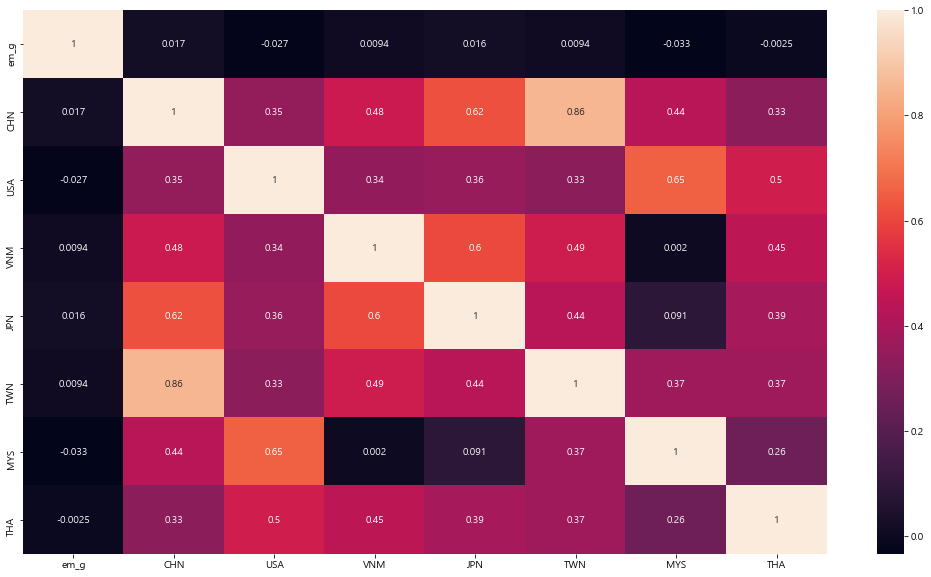

In [ ]:
plt.figure(figsize=(18,10))
sns.heatmap(final_2018.corr(), annot=True)

## 2019년 장기체류 외국인 유동인구 데이터와 음식물 쓰레기 배출량과의 상관관계(국적별) 

<AxesSubplot:>

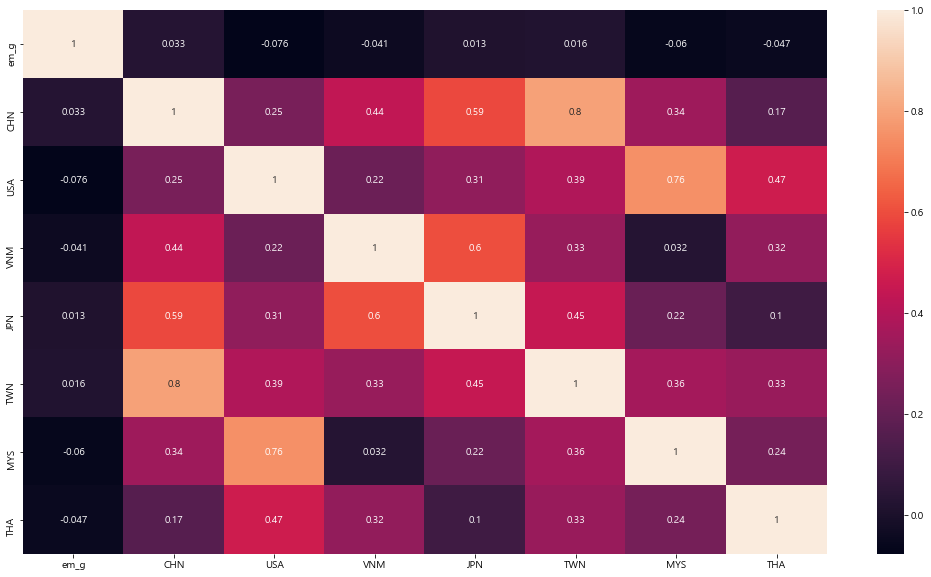

In [ ]:
plt.figure(figsize=(18,10))
sns.heatmap(final_2019.corr(), annot=True)

## 2020년 장기체류 외국인 유동인구 데이터와 음식물 쓰레기 배출량과의 상관관계(국적별) 

<AxesSubplot:>

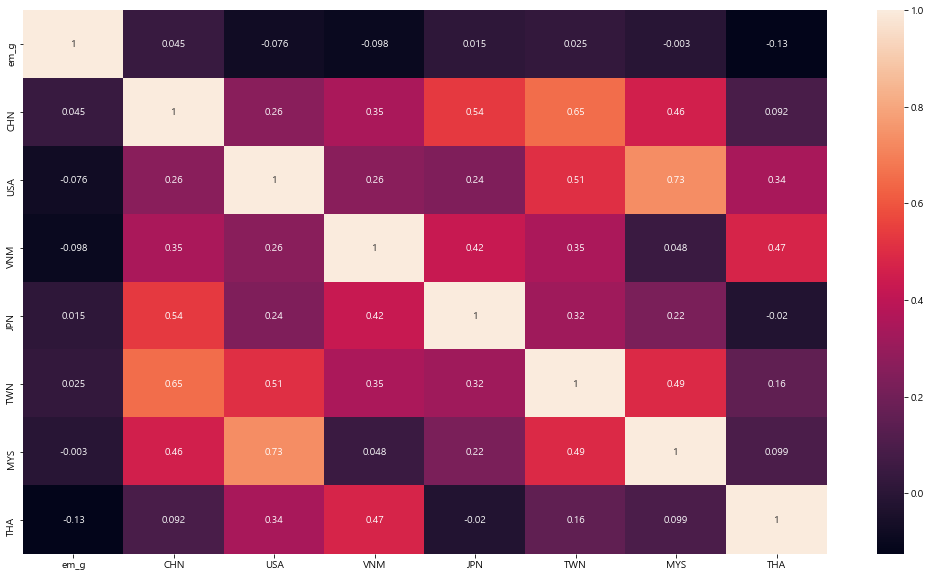

In [ ]:
plt.figure(figsize=(18,10))
sns.heatmap(final_2020.corr(), annot=True)

## 2021년 장기체류 외국인 유동인구 데이터와 음식물 쓰레기 배출량과의 상관관계(국적별) 

<AxesSubplot:>

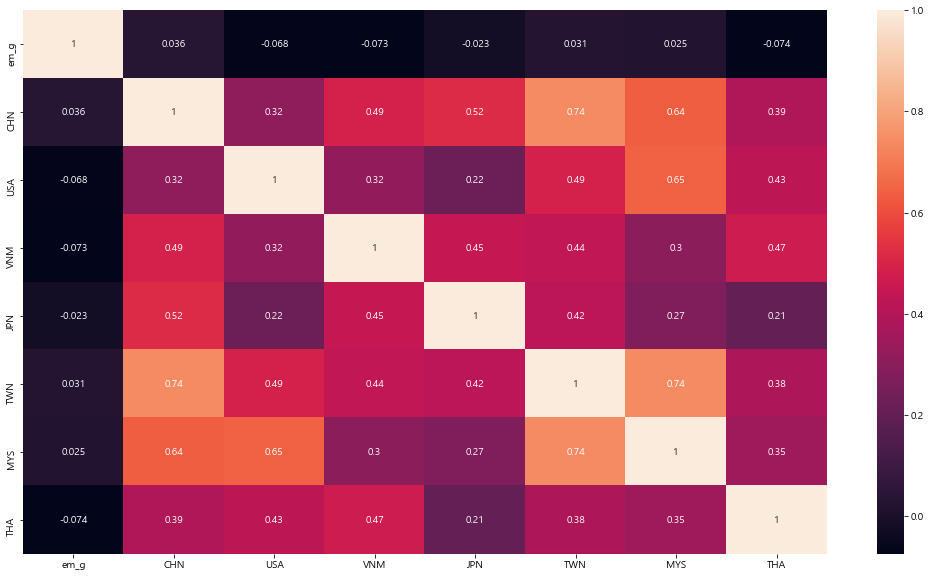

In [ ]:
plt.figure(figsize=(18,10))
sns.heatmap(final_2021.corr(), annot=True)

# 장기체류 외국인 유동인구수 비교



In [ ]:
final_year=final.groupby('연도').sum()
final_year

,em_g,CHN,USA,VNM,JPN,TWN,MYS,THA
연도,,,,,,,,
2018,29175864165,6770862905.11765194,417299968.90433258,875593284.87636769,167621260.09394062,181022266.54762688,15719027.14680075,44060252.34580286
2019,29139203229,6347339107.12380505,592725147.21222484,1128998377.06491518,148621441.82857162,185906730.71639681,26170360.52769746,54777911.87920174
2020,32242846541,6522433660.30756474,835738593.76402998,1817186236.97572136,191755738.39082766,209401727.07849491,23689214.79599768,92148393.59264208
2021,15457679164,3520186349.64723253,435548870.11086512,882997459.99409890,101618759.12674884,125606804.83072501,20549350.81150273,56099520.91800045


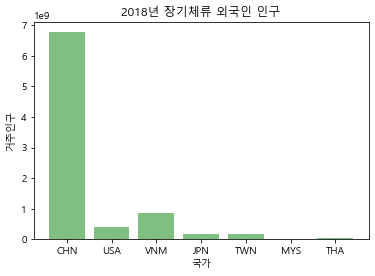

In [ ]:
x = ['CHN','USA','VNM','JPN','TWN','MYS','THA']
y = [6770862905.11765194,417299968.90433258,875593284.87636769,167621260.09394062,181022266.54762688,15719027.14680075,44060252.34580286]

plt.bar(x, y, align='center', color='green', alpha=0.5)
plt.xticks(x)

plt.title('2018년 장기체류 외국인 인구')
plt.xlabel('국가')
plt.ylabel('거주인구')

plt.show()

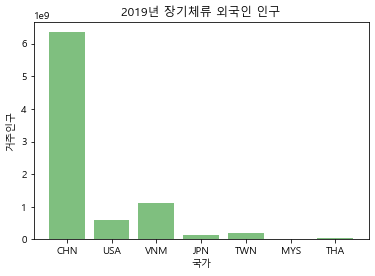

In [ ]:
x = ['CHN','USA','VNM','JPN','TWN','MYS','THA']
y = [6347339107.12380505,592725147.21222484,1128998377.06491518,148621441.82857162,185906730.71639681,26170360.52769746,54777911.87920174]

plt.bar(x, y, align='center', color='green', alpha=0.5)
plt.xticks(x)

plt.title('2019년 장기체류 외국인 인구')
plt.xlabel('국가')
plt.ylabel('거주인구')

plt.show()

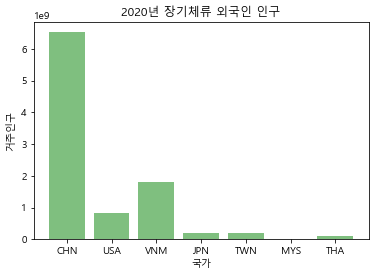

In [ ]:
x = ['CHN','USA','VNM','JPN','TWN','MYS','THA']
y = [6522433660.30756474,835738593.76402998,1817186236.97572136,191755738.39082766,209401727.07849491,23689214.79599768,92148393.59264208]

plt.bar(x, y, align='center', color='green', alpha=0.5)
plt.xticks(x)

plt.title('2020년 장기체류 외국인 인구')
plt.xlabel('국가')
plt.ylabel('거주인구')

plt.show()

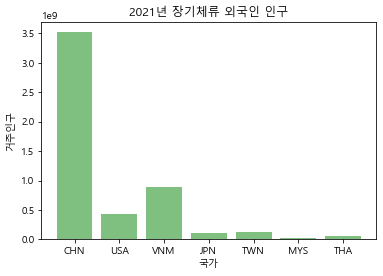

In [ ]:
x = ['CHN','USA','VNM','JPN','TWN','MYS','THA']
y = [3520186349.64723253,435548870.11086512,882997459.99409890,101618759.12674884,125606804.83072501,20549350.81150273,56099520.91800045]

plt.bar(x, y, align='center', color='green', alpha=0.5)
plt.xticks(x)

plt.title('2021년 장기체류 외국인 인구')
plt.xlabel('국가')
plt.ylabel('거주인구')

plt.show()

<AxesSubplot:>

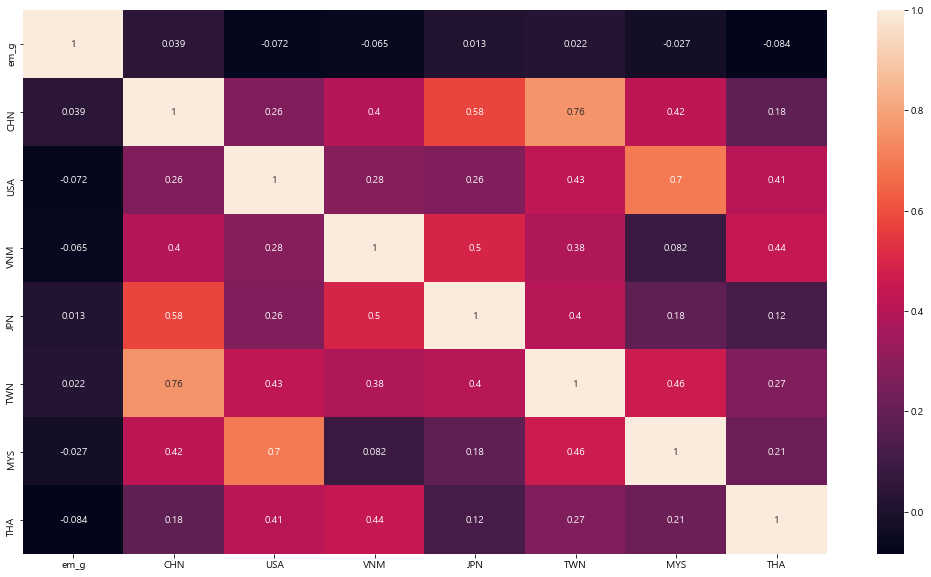

In [ ]:
plt.figure(figsize=(18,10))
sns.heatmap(final.corr(), annot=True)

## 내국인 유동인구 데이터 불러오기

In [ ]:
KOREAN = pd.read_csv('../data/01_제공데이터_update(210811)/02-1_내국인유동인구_KOREAN.csv',encoding='euc-kr')
KOREAN

,base_date,time,city,emd_cd,emd_nm,sex,age,resd_pop_cnt,work_pop_cnt,visit_pop_cnt,resd
0,2018-01-01,1,제주시,50110250,한림읍,여성,0,638.55090000,15.54000000,151.51490000,제주
1,2018-01-01,1,제주시,50110250,한림읍,여성,0,0.00000000,3.72490000,171.34580000,그외
2,2018-01-01,1,제주시,50110250,한림읍,여성,10,668.45770000,17.03080000,166.05000000,제주
3,2018-01-01,1,제주시,50110250,한림읍,여성,10,0.00000000,4.25770000,195.85390000,그외
4,2018-01-01,1,제주시,50110250,한림읍,여성,20,609.77100000,5.94900000,148.72460000,제주
...,...,...,...,...,...,...,...,...,...,...,...
47250191,2021-06-30,24,서귀포시,50130620,예래동,남성,20,0.00000000,0.00000000,599.19690000,그외
47250192,2021-06-30,24,서귀포시,50130620,예래동,남성,20,187.59900000,41.99980000,75.59960000,제주
47250193,2021-06-30,24,서귀포시,50130620,예래동,남성,10,121.84670000,0.00000000,4.51280000,제주
47250194,2021-06-30,24,서귀포시,50130620,예래동,남성,80,122.21900000,0.00000000,4.50320000,제주


###  근무 인구 비율의 경우 선형종속의 문제를 해결하고자 파생변수에서 제외

In [ ]:
KOREAN['sum']=KOREAN['resd_pop_cnt']+KOREAN['visit_pop_cnt']

## 연령대별 음식물 쓰레기에 미치는 영향을 알아보기 위해 데이터 전처리

In [ ]:
KOREAN2=KOREAN[['base_date','emd_nm','age','sum']]
KOREAN2

,base_date,emd_nm,age,sum
0,2018-01-01,한림읍,0,790.06580000
1,2018-01-01,한림읍,0,171.34580000
2,2018-01-01,한림읍,10,834.50770000
3,2018-01-01,한림읍,10,195.85390000
4,2018-01-01,한림읍,20,758.49560000
...,...,...,...,...
47250191,2021-06-30,예래동,20,599.19690000
47250192,2021-06-30,예래동,20,263.19860000
47250193,2021-06-30,예래동,10,126.35950000
47250194,2021-06-30,예래동,80,126.72220000


In [ ]:
age=KOREAN2.groupby(['base_date','emd_nm','age']).sum()
age

sum
base_date  emd_nm age               
2018-01-01 건입동    0   32565.91770000
                  10  37051.02900000
                  20  40386.45140000
                  30  46126.94970000
                  40  61677.51830000
...                              ...
2021-06-30 효돈동    40  19682.28550000
                  50  23326.19320000
                  60  19172.96250000
                  70  12658.45520000
                  80   7240.22910000

[494199 rows x 1 columns]

In [ ]:
age=age.reset_index()
age

,base_date,emd_nm,age,sum
0,2018-01-01,건입동,0,32565.91770000
1,2018-01-01,건입동,10,37051.02900000
2,2018-01-01,건입동,20,40386.45140000
3,2018-01-01,건입동,30,46126.94970000
4,2018-01-01,건입동,40,61677.51830000
...,...,...,...,...
494194,2021-06-30,효돈동,40,19682.28550000
494195,2021-06-30,효돈동,50,23326.19320000
494196,2021-06-30,효돈동,60,19172.96250000
494197,2021-06-30,효돈동,70,12658.45520000


In [ ]:
FOOD_WASTE = pd.read_csv('C:/Users/82109/Downloads/01_음식물쓰레기_FOOD_WASTE_210811_update.CSV',encoding = 'cp949')
FOOD_WASTE=FOOD_WASTE[['base_date','em_g','emd_nm']]
FOOD_WASTE

C:\Users\82109\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,base_date,em_g,emd_nm
0,2018-01-01,15500,외도동
1,2018-01-01,59800,아라동
2,2018-01-01,25350,아라동
3,2018-01-01,30000,아라동
4,2018-01-01,44050,아라동
...,...,...,...
2211440,2021-06-30,58250,한림읍
2211441,2021-06-30,111000,한림읍
2211442,2021-06-30,48300,한림읍
2211443,2021-06-30,22050,한림읍


In [ ]:
age=pd.merge(age,FOOD_WASTE,how='right',on=['base_date','emd_nm'])
age

,base_date,emd_nm,age,sum,em_g
0,2018-01-01,외도동,0.00000000,43762.98410000,15500
1,2018-01-01,외도동,10.00000000,45679.71260000,15500
2,2018-01-01,외도동,20.00000000,29222.04250000,15500
3,2018-01-01,외도동,30.00000000,48935.30510000,15500
4,2018-01-01,외도동,40.00000000,67045.18950000,15500
...,...,...,...,...,...
19888968,2021-06-30,천지동,50.00000000,11969.18910000,91200
19888969,2021-06-30,천지동,60.00000000,8931.03090000,91200
19888970,2021-06-30,천지동,70.00000000,4037.11460000,91200
19888971,2021-06-30,천지동,80.00000000,1818.78580000,91200


# 연령대별 유동인구 총량과 음식물쓰레기 배출량의 관계 분석 

In [ ]:
for i in range(0,90,10):
    part_data = age[age.age==i]
    print( i, part_data[['sum', 'em_g']].corr() )

0             sum       em_g
sum  1.00000000 0.06101089
em_g 0.06101089 1.00000000
10             sum       em_g
sum  1.00000000 0.09158368
em_g 0.09158368 1.00000000
20             sum       em_g
sum  1.00000000 0.06147560
em_g 0.06147560 1.00000000
30             sum       em_g
sum  1.00000000 0.04144321
em_g 0.04144321 1.00000000
40             sum       em_g
sum  1.00000000 0.05225109
em_g 0.05225109 1.00000000
50             sum       em_g
sum  1.00000000 0.05128653
em_g 0.05128653 1.00000000
60             sum       em_g
sum  1.00000000 0.02754251
em_g 0.02754251 1.00000000
70             sum       em_g
sum  1.00000000 0.03028799
em_g 0.03028799 1.00000000
80              sum        em_g
sum   1.00000000 -0.00364512
em_g -0.00364512  1.00000000


# 성별 유동인구와 음식물 쓰레기 배출량의 관계 분석

In [ ]:
KOREAN=KOREAN[['base_date','emd_nm','sex','sum']]

In [ ]:
KOREAN

,base_date,emd_nm,sex,sum
0,2018-01-01,한림읍,여성,790.06580000
1,2018-01-01,한림읍,여성,171.34580000
2,2018-01-01,한림읍,여성,834.50770000
3,2018-01-01,한림읍,여성,195.85390000
4,2018-01-01,한림읍,여성,758.49560000
...,...,...,...,...
47250191,2021-06-30,예래동,남성,599.19690000
47250192,2021-06-30,예래동,남성,263.19860000
47250193,2021-06-30,예래동,남성,126.35950000
47250194,2021-06-30,예래동,남성,126.72220000


In [ ]:
sex=KOREAN.groupby(['base_date','emd_nm','sex']).sum()
sex

sum
base_date  emd_nm sex                
2018-01-01 건입동    남성  180482.43030000
                  여성  171592.61850000
           구좌읍    남성  258703.94060000
                  여성  252830.89550000
           남원읍    남성  260545.59850000
...                               ...
2021-06-30 한림읍    여성  361802.96460000
           화북동    남성  415541.47780000
                  여성  398007.50570000
           효돈동    남성   67253.30260000
                  여성   64597.71290000

[109822 rows x 1 columns]

In [ ]:
sex=sex.reset_index()
sex

,base_date,emd_nm,sex,sum
0,2018-01-01,건입동,남성,180482.43030000
1,2018-01-01,건입동,여성,171592.61850000
2,2018-01-01,구좌읍,남성,258703.94060000
3,2018-01-01,구좌읍,여성,252830.89550000
4,2018-01-01,남원읍,남성,260545.59850000
...,...,...,...,...
109817,2021-06-30,한림읍,여성,361802.96460000
109818,2021-06-30,화북동,남성,415541.47780000
109819,2021-06-30,화북동,여성,398007.50570000
109820,2021-06-30,효돈동,남성,67253.30260000


In [ ]:
man=sex.iloc[0::2]
man

,base_date,emd_nm,sex,sum
0,2018-01-01,건입동,남성,180482.43030000
2,2018-01-01,구좌읍,남성,258703.94060000
4,2018-01-01,남원읍,남성,260545.59850000
6,2018-01-01,노형동,남성,788482.57350000
8,2018-01-01,대륜동,남성,225868.85390000
...,...,...,...,...
109812,2021-06-30,표선면,남성,206287.60710000
109814,2021-06-30,한경면,남성,141355.90050000
109816,2021-06-30,한림읍,남성,395633.21380000
109818,2021-06-30,화북동,남성,415541.47780000


In [ ]:
w=sex.iloc[1::2]
w.columns=['base_date','emd_nm','sex','woman']
w

,base_date,emd_nm,sex,woman
1,2018-01-01,건입동,여성,171592.61850000
3,2018-01-01,구좌읍,여성,252830.89550000
5,2018-01-01,남원읍,여성,237753.63230000
7,2018-01-01,노형동,여성,807625.56590000
9,2018-01-01,대륜동,여성,247568.09430000
...,...,...,...,...
109813,2021-06-30,표선면,여성,191048.37570000
109815,2021-06-30,한경면,여성,124628.20740000
109817,2021-06-30,한림읍,여성,361802.96460000
109819,2021-06-30,화북동,여성,398007.50570000


In [ ]:
gender_=pd.merge(man,w,how='inner',on=['emd_nm','base_date'])
gender_

,base_date,emd_nm,sex_x,sum,sex_y,woman
0,2018-01-01,건입동,남성,180482.43030000,여성,171592.61850000
1,2018-01-01,구좌읍,남성,258703.94060000,여성,252830.89550000
2,2018-01-01,남원읍,남성,260545.59850000,여성,237753.63230000
3,2018-01-01,노형동,남성,788482.57350000,여성,807625.56590000
4,2018-01-01,대륜동,남성,225868.85390000,여성,247568.09430000
...,...,...,...,...,...,...
54906,2021-06-30,표선면,남성,206287.60710000,여성,191048.37570000
54907,2021-06-30,한경면,남성,141355.90050000,여성,124628.20740000
54908,2021-06-30,한림읍,남성,395633.21380000,여성,361802.96460000
54909,2021-06-30,화북동,남성,415541.47780000,여성,398007.50570000


# 여성의 남성의 유동인구간 차이와 음식물쓰레기 배출량과의 상관관계 파악

In [ ]:
gender_['more_woman']=gender_['woman']-gender_['sum']
gender_=gender_[['base_date','emd_nm','sum','more_woman']]
gender_.columns=['base_date','emd_nm','food_waste','more_woman']

<AxesSubplot:>

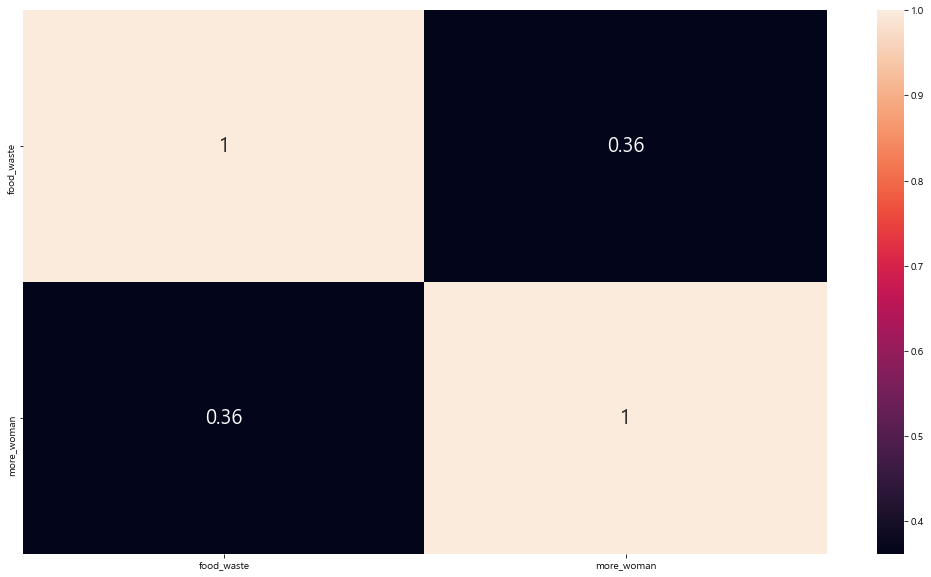

In [ ]:
plt.figure(figsize=(18,10))
sns.heatmap(gender_.corr(), annot=True,annot_kws = {'size' : 20}

)  

In [ ]:
for_train_data = pd.read_csv('../data/최종데이터/for_train_data.csv')
for_train_data

,term,emd_nm,em_g_gap,em_g_gap_rate,em_g_avg,em_g_std,resid_reg_pop_gap,resid_reg_pop_gap_rate,resid_reg_pop_avg,resid_reg_pop_std,...,deli_per_use_amt_std,food_per_use_amt_gap,food_per_use_amt_gap_rate,food_per_use_amt_avg,food_per_use_amt_std,temperature,rain,fine_dust,em_g,peak
0,2018-06-01,건입동,3468900,1.01699800,45007516,1486514.83000000,31.00000000,0.99826531,9799.00000000,12.68000000,...,395.39000000,10855.34152626,1.06976674,53964.32094488,4530.37000000,21.72166667,8.99416667,31.63333333,48187900,0
1,2018-06-01,남원읍,5900300,1.01297549,40838033,2661150.77000000,66.00000000,1.00345333,19144.00000000,26.98000000,...,367.26000000,7150.17263763,1.04461455,34163.93241398,3094.34000000,21.72166667,8.99416667,31.63333333,42287450,0
2,2018-06-01,노형동,24880750,1.01361132,259129650,10977885.73000000,52.00000000,0.99902565,53351.66666667,24.51000000,...,258.08000000,7942.75564292,0.96359199,39179.94830070,3467.90000000,21.72166667,8.99416667,31.63333333,272193365,0
3,2018-06-01,대륜동,5890450,0.99309613,55516533,2687943.44000000,196.00000000,1.01454761,13553.66666667,83.69000000,...,490.96000000,16926.37120444,0.93436554,40692.59670901,7476.91000000,21.72166667,8.99416667,31.63333333,52926700,0
4,2018-06-01,대정읍,7209750,1.13001231,39852700,3021771.90000000,86.00000000,1.00407873,21127.66666667,35.11000000,...,427.13000000,7338.89218389,0.82994300,38311.85846541,3425.49000000,21.72166667,8.99416667,31.63333333,44202200,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,2021-06-01,표선면,6873850,1.25099731,30022233,3026163.20000000,50.00000000,0.99740660,12334.33333333,20.68000000,...,1175.73000000,4022.84682966,1.01897418,34546.51315634,1767.40000000,22.73916667,5.73583333,22.60000000,42453750,0
1442,2021-06-01,한경면,3730700,1.18236643,18683783,1655205.05000000,35.00000000,1.00121668,9056.33333333,14.61000000,...,1128.05000000,9838.32373372,0.76578688,37426.26133885,4045.08000000,22.73916667,5.73583333,22.60000000,27060150,0
1443,2021-06-01,한림읍,9728016,1.15694964,63382444,4525405.15000000,53.00000000,0.99769553,21248.00000000,24.10000000,...,361.87000000,4790.68757342,0.89826240,45488.81474721,2256.27000000,22.73916667,5.73583333,22.60000000,82746990,0
1444,2021-06-01,화북동,27130700,0.95731280,95642300,11866245.24000000,13.00000000,0.99946798,24430.33333333,5.91000000,...,529.50000000,4776.47827660,0.90456516,45033.60160510,2174.08000000,22.73916667,5.73583333,22.60000000,110750050,0


### 성수기/비성수기 구별 데이터 불러오기

In [ ]:
for_train_data=for_train_data[['term','peak']]
for_train_data.columns=['base_date','peak']
for_train_data

,base_date,peak
0,2018-06-01,0
1,2018-06-01,0
2,2018-06-01,0
3,2018-06-01,0
4,2018-06-01,0
...,...,...
1441,2021-06-01,0
1442,2021-06-01,0
1443,2021-06-01,0
1444,2021-06-01,0


In [ ]:
peak=pd.merge(FOOD_WASTE,for_train_data,how='inner',on='base_date')
peak

,base_date,em_g,emd_nm,peak
0,2018-06-01,41250,일도2동,0
1,2018-06-01,41250,일도2동,0
2,2018-06-01,41250,일도2동,0
3,2018-06-01,41250,일도2동,0
4,2018-06-01,41250,일도2동,0
...,...,...,...,...
2568649,2021-06-01,28150,외도동,0
2568650,2021-06-01,28150,외도동,0
2568651,2021-06-01,28150,외도동,0
2568652,2021-06-01,28150,외도동,0


## 달별 성수기 포함 날짜수와 음식물쓰레기 배출량과의 상관관계 파악

In [ ]:
peak1=peak.groupby('peak').median().reset_index()
peak1

,peak,em_g
0,0,26650
1,1,27300
2,2,28950
3,3,35650
4,4,27450
5,5,31050
6,6,32950
7,7,30600
8,8,29350
9,9,34650


<AxesSubplot:>

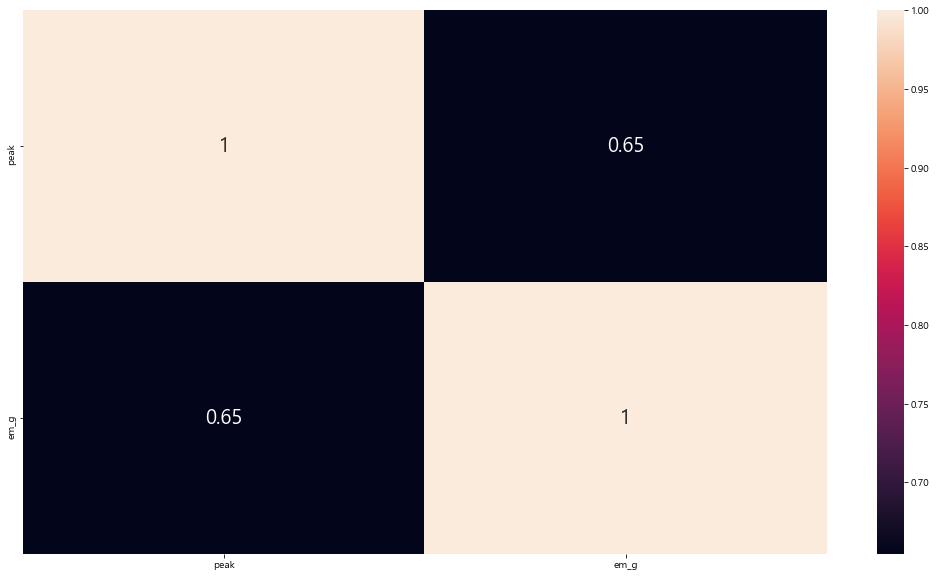

In [ ]:
plt.figure(figsize=(18,10))
sns.heatmap(peak1.corr(), annot=True,annot_kws = {'size' : 20}

)  

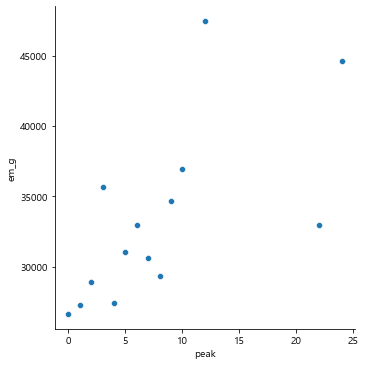

In [ ]:
sns.relplot(x ='peak', y ='em_g' , data = peak1)